In [ ]:
from avcv.all import *
import torch, torch.nn as nn
from dms_drowsiness.video_writer import Board
import onnxruntime
import numpy as np, cv2
from PIL import Image
from ple.all import *


In [ ]:
class Label:
    def __init__(self, label, video):
        self.label = label
        self.video = video
        
    def check_action_at_frame_idx(self, i):
        if isinstance(i, int):
            i = i/self.video.fps
            
        actions = []
        for action in self.label['annotation']['actionAnnotationList']:
            if i >= action['start'] and i < action['end']:
                action_idx = action['action']
                action_name = self.actionid2name[action_idx]
                actions.append(action_name)
        return actions
    @property
    def actionid2name(self):
        if hasattr(self, '_actionid2name'):
            return self._actionid2name
        ret = dict()
        for actionLabel in self.label['config']['actionLabelData']:
            ret[actionLabel['id']] = actionLabel['name']
        self._actionid2name = ret
        return ret

In [ ]:
def get_data(label_path, label_type='food'):
    if label_type == 'food':
        video_name = get_name(label_path)
        pred_json_path = f'/home/anhvth8/gitprojects/YOLOX/.cache/raw_video_predict_face_food/{video_name}/annotations/pred_mb2_face_food.json'
        root_video_name = '_'.join(video_name.split('_')[:-2])
        video_path = label_path.replace('.json', '.mp4')
        raw_feat_path = pred_json_path.replace('.json', '_2_raw_outputs.pkl')
    elif label_type == 'phone/cigarret':
        pred_json_path = f'/home/anhvth8/gitprojects/YOLOX/.cache/raw_video_predict_face_food/{video_name}/annotations/pred_mb2_face_food.json'
        t = 'smoking' if 'smoking' in video_name else 'mobile_usage'
        label_path = f'/data/DMS_Behavior_Detection/mobile_cigarret_foreignerUS/training/yoon/{t}/{video_name}.json'
        video_path = label_path.replace('.json', '.mp4')
        raw_feat_path = pred_json_path.replace('.json', '_2_raw_outputs.pkl')
    else:
        raise NotImplementedError
    assert osp.exists(pred_json_path), f'404 {pred_json_path}'
    assert osp.exists(label_path), f'404 {label_path}'
    assert osp.exists(video_path), f'404 {video_path}'
    assert osp.exists(raw_feat_path), f'404 {raw_feat_path}'
    
    return dict(
        pred_json_path=pred_json_path,
        label_path = label_path,
        video_path=video_path,
        raw_feat_path=raw_feat_path
    )

## Read 2d video feat

In [ ]:
def convert_flatten_to_2d_feature(flatten_sample):
    feat_sizes = [416//8, 416//16, 416//32]
    # reg_orig_shape = np.array(reg_orig_shape)**2
    cur_i = 0
    feats = []
    for feat_size in feat_sizes:
        a = cur_i
        b = a+feat_size**2
        cur_i = b
        feats.append(flatten_sample[a:b].reshape(feat_size, feat_size, -1))
    return feats

def read_raw_feat_one_video(path):
    data = dict(mmcv.load(path))
    # for k in data:
    #     data[k] = convert_flatten_to_2d_feature(data[k])
    return data
    # list_json_paths[0]['raw_feat_path']

In [ ]:
# 

In [ ]:
def anns2tensor(img, anns):
    h, w = img['height'], img['width']
    tensor = []
    for ann in anns:
        x,y,w,h = ann['bbox']
        x /=img['width']
        w /=img['width']
        y /=img['height']
        h /=img['height']
        s = ann['score']
        cat = ann['category_id']
        tensor.append([x,y,w,h,s, cat])
    return np.array(tensor)

In [ ]:

def get_y(actions):
    return action2id[str(actions)]

def get_x_tensor(tensor):
    zt = np.zeros([1,6], dtype=np.float32)
    def get_tensor_cat(cat):
        if len(tensor) == 0:
            return zt
        
        _t = tensor[tensor[:,-1] ==cat]
        
        if len(_t):
            max_id = _t[:,-2].argmax()
            _t = _t[max_id][None]
        else:
            return zt
            
        return _t
    return np.concatenate([get_tensor_cat(i) for i in range(1, 7)])

In [ ]:
def get_M(input_size = [224, 416], num_cls=6):
    """
        return list of mapping [old_start, old_end, new_start, new_end ]
    """
    M = []
    target_f_size = []
    
    cur_i = 0
    o_cur_i = 0

    for i in [8,16,32]:
        h, w = input_size
        _h, _w = h//i, w//i
        _oh = _ow = 416//i

        a, b = cur_i,cur_i +_h*_w
        oa, ob = o_cur_i,o_cur_i +_oh*_oh
        cur_i = b
        o_cur_i = ob
        M.append([oa, ob, _h*_w, _h, _w])
        
    return M, _h*_w*num_cls

INP_SHAPE = (224,416)
INP_SHAPE_STR = '_'.join([str(_) for _ in INP_SHAPE])
M, IN_CHANNEL_CLS = get_M(INP_SHAPE)
M, IN_CHANNEL_CLS, INP_SHAPE_STR

([[0, 2704, 1456, 28, 52], [2704, 3380, 364, 14, 26], [3380, 3549, 91, 7, 13]],
 546,
 '224_416')

In [ ]:

def convert_f(f):
    fs = []
    for oa,ob,ab,_,_ in M:
        # print(oa,ob,ab)
        fs.append(f[oa:ob][:ab].reshape(-1, 11))
    feat1d = np.concatenate(fs)
    return preproc_feat1d(feat1d)

def preproc_feat1d(x):
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)[None]
    x = x[...,4:5]*x[...,5:]
    xs = []
    cur_i = 0
    for i, _ in enumerate(M):
        h,w = _[-2:]
        _x = x[:, cur_i:cur_i+h*w].reshape([-1, h, w, 6]).permute([0,3,1,2])

        pool_size = 2**(2-i)
        _x = nn.functional.max_pool2d(_x, pool_size)
        cur_i += h*w
        xs.append(_x)
    fuse = sum(xs)
    return fuse.numpy()[0]

In [ ]:
list_json_paths = []


label_paths  = glob('/data/DMS_Behavior_Detection/RawVideos/Action_Eating/**/*.json', recursive=True)
for label_path in label_paths:
    try:
        json_paths = get_data(label_path, 'food')
        list_json_paths.append(json_paths)
    except Exception as e:
        print(e)
        pass

label_paths  = glob('/data/DMS_Behavior_Detection/mobile_cigarret_foreignerUS/*/**/*.json', recursive=True)
print(f'{len(label_paths)=}')
for label_path in label_paths:
    try:
        json_paths = get_data(label_path, 'food')
        list_json_paths.append(json_paths)
    except Exception as e:
        print(e)
        pass
len(list_json_paths)

404 /home/anhvth8/gitprojects/YOLOX/.cache/raw_video_predict_face_food/hungng_Sensing_Session0_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b_eating_0017/annotations/pred_mb2_face_food_2_raw_outputs.pkl
404 /home/anhvth8/gitprojects/YOLOX/.cache/raw_video_predict_face_food/hoangnh42_Sensing_Session0_CAMc_1b_2b_3a_4c_5b_6b_7b_8a_9a_10b_11b_12b_13b_14a_15b_16f_17a_18a_19a_20b_eating_0011/annotations/pred_mb2_face_food_2_raw_outputs.pkl
len(label_paths)=67


107

In [ ]:
def collect_data(inp):
    index, json_paths = inp
    v = mmcv.VideoReader(json_paths['video_path'])
    label = Label(mmcv.load(json_paths['label_path']), v)
    cc = CocoDataset(json_paths['pred_json_path'])
    data = []
    # raw_feat2d = read_raw_feat_one_video(json_paths['raw_feat_path'])
    for i, frame in enumerate(v):
        actions = label.check_action_at_frame_idx(i)
        anns = cc.gt.imgToAnns[i]
        img = cc.gt.imgs[i]
        tensor = None#anns2tensor(img, anns)
        img_path = osp.join(cc.img_dir, img['file_name'])
        feat = None#raw_feat2d[img['id']]
        data.append((actions[0] if len(actions) else 'none' , index, img_path, img['id']))
        
    return data


In [ ]:
%%time
CACHE_DF_PATH = '/tmp/eating_cache_data_df.pkl'
if not osp.exists(CACHE_DF_PATH):
    list_json_paths = []


    label_paths  = glob('/data/DMS_Behavior_Detection/RawVideos/Action_Eating/**/*.json', recursive=True)
    for label_path in label_paths:
        try:
            json_paths = get_data(label_path, 'food')
            list_json_paths.append(json_paths)
        except Exception as e:
            print(e)
            pass

    label_paths  = glob('/data/DMS_Behavior_Detection/mobile_cigarret_foreignerUS/*/**/*.json', recursive=True)
    print(f'{len(label_paths)=}')
    for label_path in label_paths:
        try:
            json_paths = get_data(label_path, 'food')
            list_json_paths.append(json_paths)
        except Exception as e:
            print(e)
            pass
    len(list_json_paths)    
    
    
    print('Collecting data from scratch')
    data = multi_thread(collect_data, list(enumerate(list_json_paths)), verbose=1, pbar_iterval=10)
    all_data = []
    for _ in data: all_data += _

    df = pd.DataFrame(all_data, columns=['action', 'video_index', 'img_path', 'img_id'])
    #-smocking->smoking
    ids = df[df['action'] == 'smocking'].index
    df.loc[ids, 'action'] = 'smoking'
    mmcv.dump(df, CACHE_DF_PATH)
else:
    print(f'Load data from {CACHE_DF_PATH=}')
    df = mmcv.load(CACHE_DF_PATH)

Load data from CACHE_DF_PATH='/tmp/eating_cache_data_df.pkl'
CPU times: user 59.5 ms, sys: 26.6 ms, total: 86.1 ms
Wall time: 84.4 ms


In [ ]:
val_users = ['hungng', 'chungtd12', 'thomp4', 'thuyhv5']
df['username'] = df.img_path.apply(lambda x:x.split('/')[-3].split('_')[0])
df['is_val'] = df['username'].apply(lambda x: x in val_users)

In [ ]:
df[df.is_val].groupby('action').size()


action
eating    1186
none      3314
dtype: int64

In [ ]:
from scripts.export_onnx import model_wraper, mb2_yolox

IN_CHANNEL_CLS=546
<All keys matched successfully>


In [ ]:
def load_image_tensor(path):
    img = mmcv.imread(path, 0)
    img = mmcv.imrescale(img, INP_SHAPE)
    img = mmcv.impad(img, shape=INP_SHAPE, pad_val=114)
    img = img[None].astype(np.float32)
    return torch.from_numpy(img)

class ImageDataset:
    def __init__(self, img_paths, y=None):
        self.img_paths = img_paths
        self.y = y if y is not None else [0]*len(img_paths)
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, i):
        return load_image_tensor(self.img_paths[i]), self.y[i]


In [ ]:
_id2action = dict(enumerate(df['action'].apply(str).unique().tolist()))
action2id = {v:k for k, v in _id2action.items()}
print(action2id)


{'eating': 0, 'none': 1, 'mobile usage': 2, 'smoking': 3}


## Split train/val

In [ ]:
df['x'] = df['img_path']
df['y'] = df.action.apply(lambda x: action2id[x])

In [ ]:
# df

In [ ]:
# df_val.is_val

In [ ]:
from sklearn.model_selection import train_test_split

# labels = df.action.unique().tolist()
# labels

# df_train = df[df.video_index.apply(lambda i: i % 5 != 0)]
# df_val = df[df.video_index.apply(lambda i: i % 5 == 0)]
# print(f'{len(df_train)=}, {len(df_val)=}')

# def df2xy(df):
#     return df.img_path.values, np.array(df.y.tolist())

xtrain, ytrain = df[~df.is_val]['x'].tolist(), df[~df.is_val]['y'].tolist()
xval, yval = df[df.is_val]['x'].tolist(), df[df.is_val]['y'].tolist()
print(len(xtrain), len(xval))

79525 4500


In [ ]:
# xtrain

## Dataset

In [ ]:
# xtrain

In [ ]:
import torch.utils.data as td
class YOutDataset(ImageDataset):
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        return  *res,self.img_paths[idx]


### Get sample data

In [ ]:
ds = YOutDataset(df.img_path, df.y)
dl = td.DataLoader(ds, 2, shuffle=1)
x,y, img_paths = next(iter(dl))

## MyLit

In [ ]:
from scripts.export_onnx import mb2_yolox, SimpleCLS2D

In [ ]:
class ModelWrapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.mb2_yolox = mb2_yolox.requires_grad_(False)
        self.classifier = SimpleCLS2D()
        
    def forward(self, img):
        self.mb2_yolox.eval()
        x = self.mb2_yolox(img)
        x = self.classifier(x)
        return x

In [ ]:



class MyLit(LitModel):
    def forward_loss(self, batch, batch_idx, mode):
        x, y = batch[:2]
        y_onehot = nn.functional.one_hot(y, 4).float()
        logits = self(x).reshape_as(y_onehot)
        probs = logits.sigmoid()
        loss = self.loss_fn(logits, y_onehot)
        
        mask = y!=1
        if mask.sum():
            accs = (y_onehot[mask] == (probs[mask]>0.5).float()).float().mean()
            self.log(f"{mode}_acc", accs, prog_bar=True,
                     rank_zero_only=True, on_epoch=True, batch_size=mask.sum())
        self.log(f"{mode}_loss", loss, prog_bar=True,
                 rank_zero_only=True, on_epoch=True)

        return loss
    def training_step(self, b,i): return self.forward_loss(b,i,'training')
    def validation_step(self, b,i): return self.forward_loss(b,i,'val')

## PLData

In [ ]:
from ple.all import *
import torch.utils.data as td
import pytorch_lightning as pl
from fastcore.all import *

class PLData(pl.LightningDataModule):
    def __init__(self, **kwargs):
        super().__init__()
        store_attr(**kwargs)

    def train_dataloader(self):
        dataset = YOutDataset(xtrain, ytrain)
        return td.DataLoader(dataset, self.batch_size, num_workers=self.num_workers, drop_last=True, shuffle=True)

    def val_dataloader(self):
        dataset = YOutDataset(xval, yval)
        return td.DataLoader(dataset, self.batch_size, num_workers=self.num_workers,drop_last=True)
pldata = PLData(batch_size=64, num_workers=0)
trainloader = pldata.train_dataloader()
x,y, img_paths = next(iter(trainloader))
print(x.shape, y.shape)

torch.Size([64, 1, 224, 416]) torch.Size([64])


## TriStageExp

In [ ]:
class TriStageExp(BaseExp):

    def __init__(self, exp_name='EXPNAME', 
                 batch_size=64, 
                 num_workers=2, 
                 devices=2,
                 strategy='dp', 
                 **kwargs):
        super().__init__()
        store_attr(**kwargs)

    def get_model(self):
        dl = self.get_data_loader().train_dataloader()
        sched = fn_schedule_cosine_with_warmpup_decay_timm(
            num_epochs=self.max_epochs,
            num_steps_per_epoch=len(dl)//self.devices,
            num_epochs_per_cycle=self.max_epochs//self.num_lr_cycles,
            min_lr=1/100,
            cycle_decay=0.7,
        )
        optim = lambda params:torch.optim.Adam(params)

        return MyLit(self.model, create_optimizer_fn=optim,
                                   create_lr_scheduler_fn=sched, loss_fn=self.loss_fn)

    def get_data_loader(self):
        return PLData(batch_size=self.batch_size, num_workers=self.num_workers)

    def get_trainer(self, **kwargs):
        from ple.trainer import get_trainer
        return get_trainer(self.exp_name, 
                              max_epochs=self.max_epochs, 
                              gpus=self.devices,
                           strategy=self.strategy,
                           **kwargs,

                          )

exp = TriStageExp(exp_name=f'simple_nn/{INP_SHAPE_STR}', batch_size=256, 
                  num_workers=4, devices=1, model=ModelWrapper(), max_epochs=30,
                 loss_fn = nn.functional.binary_cross_entropy_with_logits)


In [ ]:
# lit_model.model.classifier.forward??

In [ ]:
lit_model = exp.get_model()
lit_model.cpu().training_step([x,y],1)

2022-09-27 11:38:01.543 | INFO     | ple.lit_model:fn_schedule_cosine_with_warmpup_decay_timm:66 - num_cycles=3
/home/anhvth8/.conda/envs/py38/lib/python3.8/site-packages/pytorch_lightning/core/module.py:386: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


tensor(0.7763, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [ ]:
trainer = exp.get_trainer()
trainer.fit(lit_model, exp.get_data_loader())

2022-09-27 16:33:53.688 | INFO     | ple.trainer:get_trainer:34 - Log root dir: lightning_logs/simple_nn/224_416/17
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs/simple_nn/224_416/17/tb_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name  | Type         | Params
---------------------------------------
0 | model | ModelWrapper | 851 K 
---------------------------------------
21.2 K    Trainable params
830 K     Non-trainable params
851 K     Total params
3.406     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/anhvth8/.conda/envs/py38/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:86: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 256. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Test

In [ ]:
# lit_model = exp.get_model();

# lit_model.load_from_checkpoint('lightning_logs/simple_nn/00/ckpts/epoch=6-val_acc=0.74.ckpt', model=lit_model.model)
# lit_model = lit_model.cuda().requires_grad_(False).eval()

In [ ]:


session = onnxruntime.InferenceSession('/home/anhvth8/gitprojects/YOLOX/out.onnx')

def predict_onnx(img_path):
    inp = load_image_tensor(img_path).numpy()[None]
    ort_inputs = {session.get_inputs()[0].name: inp.astype(np.float32)}
    probs = session.run(None, ort_inputs)[0]
    return torch.from_numpy(probs).sigmoid().numpy().squeeze().tolist()

res = predict_onnx('/tmp/guiemanhtest224.png')
# res =[0.9980290532112122,0.09712985157966614,2.980232238769531e-07,0.0006951689720153809]
print(res)

[0.8277732729911804, 0.006765434052795172, 0.03476791828870773, 0.16865961253643036]


### Gửi em ảnh test

In [ ]:
1

1

In [ ]:
# st = torch.load('lightning_logs/simple_nn/224_416/03/ckpts/epoch=0-val_acc=0.86.ckpt')['state_dict']
# new_st = {}
# for k, v in st.items():
#     new_st[k[6:]] = v
# res = model_wraper.classifier.load_state_dict(new_st)
# print(res)
# model_wraper.eval().requires_grad_(False);

In [ ]:
x,y,img_paths = next(iter(pldata.train_dataloader()))

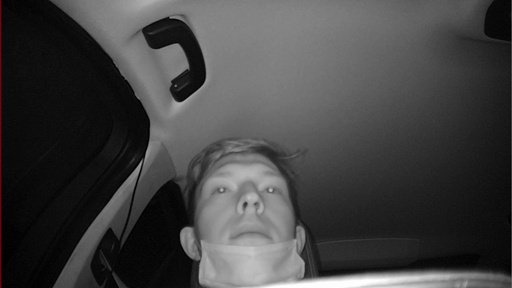

In [ ]:
Image.open(img_paths[0])

In [ ]:
val_json_paths = []
for json_paths in list_json_paths:
    username = json_paths['pred_json_path'].split('/')[-3].split('_')[0]
    if username in val_users:
        val_json_paths.append(json_paths)


In [ ]:
# @torch.inference_mode()
def predict_model_wrapper(img_path, model, device='cuda'):
    model.eval().to(device)
    with torch.no_grad():
        img = load_image_tensor(img_path)[None].to(device)
        probs = lit_model(img).cpu()
    return probs[0].tolist()


In [ ]:
val_json_paths[0]

{'pred_json_path': '/home/anhvth8/gitprojects/YOLOX/.cache/raw_video_predict_face_food/hungng_Sensing_Session0_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b_eating_0003/annotations/pred_mb2_face_food.json',
 'label_path': '/data/DMS_Behavior_Detection/RawVideos/Action_Eating/hungng_Sensing_Session0_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b/hungng_Sensing_Session0_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b_eating_0003.json',
 'video_path': '/data/DMS_Behavior_Detection/RawVideos/Action_Eating/hungng_Sensing_Session0_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b/hungng_Sensing_Session0_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b_eating_0003.mp4',
 'raw_feat_path': '/home/anhvth8/gitprojects/YOLOX/.cache/raw_video_predict_face_food/hungng_Sensing_Session0_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b_ea

In [ ]:
df

In [ ]:
# val_ids = df_train.video_index.unique().tolist()
# print('Num of val', len(val_ids))
# val_json_paths = [list_json_paths[i] for i in val_ids]
# # val_json_paths
json_paths = np.random.choice(val_json_paths)
json_paths

{'pred_json_path': '/home/anhvth8/gitprojects/YOLOX/.cache/raw_video_predict_face_food/hungng_Sensing_Session0_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b_eating_0001/annotations/pred_mb2_face_food.json',
 'label_path': '/data/DMS_Behavior_Detection/RawVideos/Action_Eating/hungng_Sensing_Session0_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b/hungng_Sensing_Session0_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b_eating_0001.json',
 'video_path': '/data/DMS_Behavior_Detection/RawVideos/Action_Eating/hungng_Sensing_Session0_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b/hungng_Sensing_Session0_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b_eating_0001.mp4',
 'raw_feat_path': '/home/anhvth8/gitprojects/YOLOX/.cache/raw_video_predict_face_food/hungng_Sensing_Session0_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b_ea

In [ ]:
from IPython.display import clear_output

class Visualize:
    def __init__(self, video_or_json_paths):
        if isinstance(video_or_json_paths, dict):
            json_paths = video_or_json_paths
            self.cc = CocoDataset(json_paths['pred_json_path'])
            self.label = Label(mmcv.load(json_paths['label_path']), mmcv.VideoReader(json_paths['video_path']))
            self.input_type = 'coco'
        elif isinstance(video_or_json_paths, str):
            self.video = mmcv.VideoReader(video_or_json_paths)
            self.input_type = 'video'

    def visualize_coco_frame(self, img):
        cc, label = self.cc, self.label
        board = Board(num_lines=6, line_w=500)
        frame = self.cc.visualize(img, score_thr=0.05);
        img_info = cc.gt.imgs[img]
        image = osp.join(cc.img_dir, img_info['file_name'])
        lbl = label.check_action_at_frame_idx(img)
        lbl = lbl[0] if len(lbl) else lbl
        probs = predict_onnx(image)
        for class_idx in range(4):
            action = _id2action[class_idx]
            action = action + ' '*(12-len(action))
            score = probs[class_idx]
            board.set_line_text(class_idx, action, score)
        if lbl is not None:
            board.set_line_text(5, f'Label: {lbl}')

        vis = board.img_concat(frame)
        return vis
    
    def visualize_video_frame(self, img):
        
        board = Board(num_lines=6, line_w=500)
        frame = img = mmcv.imread(img)
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        probs = predict_onnx(img)
        
        for class_idx in range(4):
            action = _id2action[class_idx]
            action = action + ' '*(12-len(action))
            score = probs[class_idx]
            board.set_line_text(class_idx, action, score)

        vis = board.img_concat(frame)
        return vis

    
    def write_video(self):
        if self.input_type == 'coco':
            vis_list = multi_thread(self.visualize_coco_frame, self.cc.img_ids, 1, desc='Get Visualize Imgs')
        else:
            vis_list = []
            pbar = mmcv.ProgressBar(len(self.video))
            for frame_idx, img in enumerate(self.video):
                if frame_idx%3==0:
                    vis_list.append(self.visualize_video_frame(img))
                if frame_idx%10 == 0: pbar.update(10)

        images_to_video(vis_list, 'vis.mp4', output_size=(800, 300))
# Visualize('/tmp/toanbd1_eating_smoking_phoneusage_distraction_drowsiness.avi').write_video()
Visualize(json_paths).write_video()


2022-09-27 11:40:14.505 | INFO     | avcv.process:multi_thread:25 - Get Visualize Imgs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 880/872, 70.5 task/s, elapsed: 12s, ETA:     0s

2022-09-27 11:40:27.011 | INFO     | avcv.process:multi_thread:34 - multi_thread visualize_coco_frame, Get Visualize Imgs
2022-09-27 11:40:27.015 | INFO     | avcv.utils:images_to_video:267 - Write video, output_size: (800, 300)


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 872/872, 229.4 task/s, elapsed: 4s, ETA:     0s

2022-09-27 11:40:30.818 | INFO     | avcv.utils:images_to_video:277 - -> /home/anhvth8/gitprojects/YOLOX/vis.mp4
